In [62]:
import os
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset,DataLoader, random_split,Dataset
from torchvision.io import read_image
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torchvision.utils import make_grid
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

batch_size=16

Using cuda device


In [63]:
class_list = ['Cow', 'Horse']
class_num = len(class_list)

In [64]:
z_size = 10 # Size of z latent vector (i.e. size of generator input)
img_size = 64
ngpu = 16 # Number of GPUs available
nc = 3   # Number of channels in the training images. For color images this is 3

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
class CustomImageDataset(Dataset):
    def __init__(self, transform=None, target_transform=None, mode='GAN',folder_label = ''):
      #Mode can be Train,Test,Generated
      #folder_label can be Horse,Cow for train/generated and Shape1,Shape2 for test
        self.path = os.path.join('/content/drive/MyDrive/Newdata', mode,folder_label)
        self.path = [os.path.join(self.path, i) for i in os.listdir(self.path)]
        self.img_dir = self.path
        self.nbre_images = len(self.img_dir)
        if folder_label == 'Cow':
          label_value = 0
        elif folder_label == 'Horse':
          label_value = 1
        self.labels = np.array([label_value for i in range(self.nbre_images)])
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.nbre_images

    def __getitem__(self, idx):
        image = read_image(self.img_dir[idx])
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((img_size,img_size)),
            transforms.ToTensor()
            ])
switch = [transform]

trainset_cow = CustomImageDataset(transform=switch[0],mode = 'Train',folder_label = 'Cow')
trainset_horse = CustomImageDataset(transform=switch[0],mode = 'Train',folder_label = 'Horse')
# Create a ConcatDataset
trainset = ConcatDataset([trainset_cow, trainset_horse])
#Load to trainloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)

def plot_images(imgs, grid_size = 5):
    fig = plt.figure(figsize = (8,8))
    columns = rows = grid_size
    plt.title("Training Images")

    for i in range(1, columns*rows +1):
        plt.axis("off")
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgs)
    plt.show

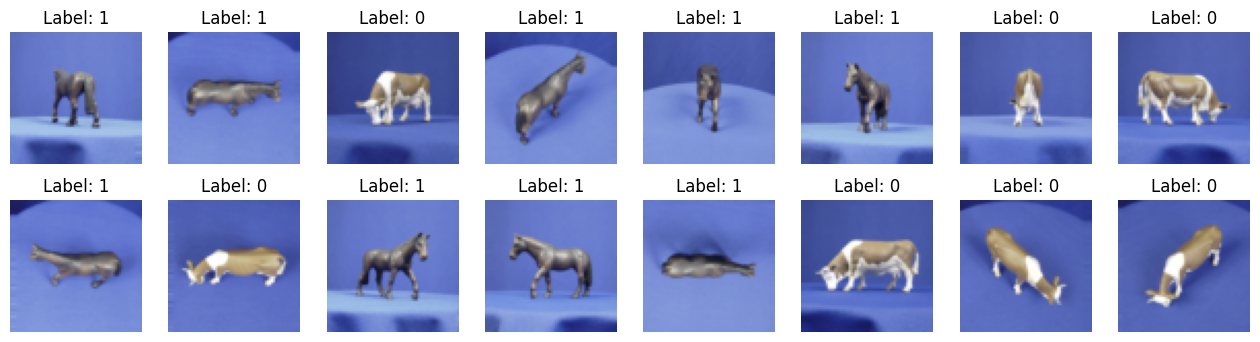

In [67]:
#Plotting train images
train_features, train_labels = next(iter(trainloader))

fig, axes = plt.subplots(2, 8, figsize=(16, 4))

for i in range(batch_size):
    img = train_features[i].permute(1, 2, 0)
    label = train_labels[i].item()

    # Display the image
    axes[i // 8, i % 8].imshow(img, cmap="gray")
    axes[i // 8, i % 8].axis('off')  # Turn off axis labels for clarity
    axes[i // 8, i % 8].set_title(f'Label: {label}')

plt.show()

In [68]:
ngf = 64 # Size of feature maps in generator
class Generator(nn.Module):
    def __init__(self, ngpu, z_size, img_size, class_num):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.z_size = z_size
        self.img_size = img_size
        self.label_emb = nn.Embedding(class_num, z_size)
        self.main = nn.Sequential(

            nn.ConvTranspose2d( z_size+z_size, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf*2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, input, labels):
        # One-hot vector to embedding vector
        c = self.label_emb(labels)
        # Concat image & label
        x = torch.cat((input, c),dim = 1)
        x = x.view(-1, self.z_size + self.z_size, 1, 1)
        # Generator out
        x = self.main(x)

        return x


myGenerator = Generator(ngpu,z_size, img_size, class_num).to(device)

# generator_layer_size = [256, 512, 1024]
# class Generator(nn.Module):
#     def __init__(self, generator_layer_size, z_size, img_size, class_num):
#         super().__init__()

#         self.z_size = z_size
#         self.img_size = img_size

#         self.label_emb = nn.Embedding(class_num, class_num)

#         self.model = nn.Sequential(
#             nn.Linear(self.z_size + class_num, generator_layer_size[0]),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(generator_layer_size[0], generator_layer_size[1]),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(generator_layer_size[1], generator_layer_size[2]),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(generator_layer_size[2], self.img_size * self.img_size * nc),
#             nn.Tanh()
#         )

#     def forward(self, z, labels):

#         # Reshape z
#         z = z.view(-1, self.z_size)

#         # One-hot vector to embedding vector
#         c = self.label_emb(labels)
#         # Concat image & label
#         x = torch.cat([z, c], 1)

#         # Generator out
#         out = self.model(x)

#         return out.view(-1,nc, self.img_size, self.img_size)
# myGenerator = Generator(generator_layer_size, z_size, img_size, class_num).to(device)

torch.Size([16, 10])
tensor([0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1], device='cuda:0')
torch.Size([16, 3, 64, 64])


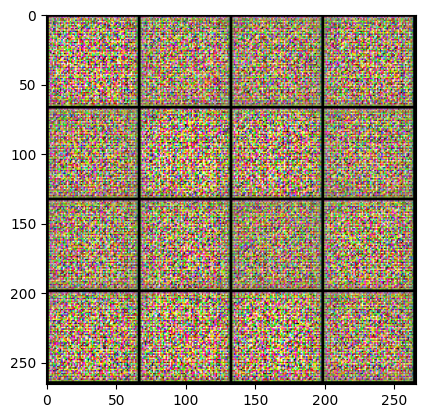

In [69]:
# Generate random noise and labels
random_noise = Variable(torch.randn(batch_size, z_size)).to(device)
label = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)
print(random_noise.shape)
print(label)
# Forward pass through the generator
generated_image = myGenerator(random_noise, label).data.cpu()
print(generated_image.shape)
# # Convert the generated image to NumPy for visualization
# generated_image = generated_image.detach().squeeze().permute(1, 2, 0).cpu().numpy()

# # Display the generated image
# plt.imshow(generated_image)
# plt.show()

# Show images
grid = make_grid(generated_image, nrow=4, normalize=True).permute(1,2,0).numpy()
plt.imshow(grid)
plt.show()

In [70]:
# discriminator_layer_size = [1024, 512, 256]
# class Discriminator(nn.Module):
#     def __init__(self, ngpu, img_size, class_num):
#         super(Discriminator, self).__init__()
#         self.ngpu = ngpu
#         self.label_emb = nn.Embedding(class_num, class_num)
#         self.img_size = img_size

#         self.main = nn.Sequential(

#             nn.Linear(self.img_size * self.img_size*3 + class_num, discriminator_layer_size[0]),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.3),
#             nn.Linear(discriminator_layer_size[0], discriminator_layer_size[1]),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.3),
#             nn.Linear(discriminator_layer_size[1], discriminator_layer_size[2]),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.3),
#             nn.Linear(discriminator_layer_size[2], 1),
#             nn.Sigmoid()

#         )

#     def forward(self, x, labels):
#         # Reshape fake image
#         x = x.view(-1, self.img_size * self.img_size * 3)

#         # One-hot vector to embedding vector
#         c = self.label_emb(labels)

#         # Concat image & label
#         x = torch.cat([x, c], 1)

#         # Discriminator out
#         out = self.main(x)

#         return out.view(-1,1,1,1)


# myDiscriminator = Discriminator(ngpu, img_size, class_num).to(device)

ndf = 64 # Size of feature maps in discriminator
class Discriminator(nn.Module):
    def __init__(self, ngpu, img_size, class_num):
          super(Discriminator, self).__init__()
          self.ngpu = ngpu
          self.label_emb = nn.Embedding(class_num, 1)
          self.img_size = img_size

        #   self.process1 =nn.Sequential(

        #       nn.Conv2d(1, ndf, 4, 2, 1, bias=False),
        #       nn.LeakyReLU(0.2, inplace=True),

        #       nn.Conv2d(ndf, ndf, 5, 2, 1, bias=False),
        #       nn.BatchNorm2d(ndf),
        #       nn.LeakyReLU(0.2, inplace=True),


        # )

        #   self.process2 = nn.Sequential(

        #       nn.Conv2d(17*ndf, ndf*20, 4, 2, 1, bias=False),
        #       nn.BatchNorm2d(ndf*20),
        #       nn.LeakyReLU(0.2, inplace=True),

        #       nn.Conv2d(ndf * 20, 1, 3, 1, 0, bias=False),
        #       nn.Sigmoid()
        # )

          self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        # # Reshape fake image
        # x = x.view(-1, self.img_size * self.img_size * nc)

        # # One-hot vector to embedding vector
        # c = self.label_emb(labels)

        # # Concat image & label
        # x = torch.cat([x, c], 1)
        # x = x.view(x.size(0), 1, 1229, 10)
        # x = self.process1(x)

        # x = x.view(x.size(0), 17*ndf, 6, 6)  # Reshape for convolutional layer
        # out = self.process2(x)

        # # x = x.view(x.size(0), int(ndf/16), 48, 48)


        c = self.label_emb(labels)
        x_padded = F.pad(x, (1, 1, 1, 1), value=0)
        for i in range(len(x)):
          x_padded[i] = F.pad(x[i], (1, 1, 1, 1), value=c[i].item())

        # Discriminator out
        out = self.main(x)

        return out



myDiscriminator = Discriminator(ngpu, img_size, class_num).to(device)

tensor([[[[0.7118]]],


        [[[0.7306]]],


        [[[0.7316]]],


        [[[0.7567]]],


        [[[0.7161]]],


        [[[0.7627]]],


        [[[0.7235]]],


        [[[0.7802]]],


        [[[0.7137]]],


        [[[0.7734]]],


        [[[0.7831]]],


        [[[0.7195]]],


        [[[0.7219]]],


        [[[0.7678]]],


        [[[0.7124]]],


        [[[0.7610]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


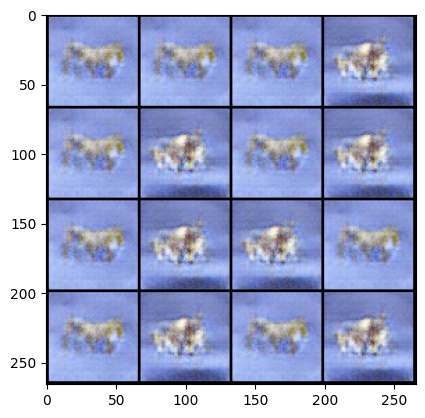

In [79]:
# Building z
z = Variable(torch.randn(batch_size, z_size)).to(device)

# Building fake labels
fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)

# Generating fake images
fake_images = myGenerator(z, fake_labels)

# Disciminating fake images
fake_validity = myDiscriminator(fake_images, fake_labels)
print(fake_validity)
# Show images
grid = make_grid(fake_images.data.cpu(), nrow=4, normalize=True).permute(1,2,0).numpy()
plt.imshow(grid)
plt.show()

In [72]:
def weights_init(m):  #custom weights initialization called on myGenerator and myDiscriminator
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

myGenerator.apply(weights_init)
myDiscriminator.apply(weights_init)

Discriminator(
  (label_emb): Embedding(2, 1)
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [73]:
# Setup Adam optimizers for both G and D
d_optimizer = optim.Adam(myDiscriminator.parameters(), lr = 0.0002, betas = (0.5, 0.999))
g_optimizer = optim.Adam(myGenerator.parameters(), lr = 0.0002, betas = (0.5, 0.999))
# Initialize BCELoss function
criterion  = nn.BCELoss()

Starting Training Loop...
Starting epoch 1...
g_loss: 7.71146821975708, d_loss: 4.188752174377441
Starting epoch 2...
g_loss: 10.000422477722168, d_loss: 1.2311204671859741
Starting epoch 3...
g_loss: 13.50575065612793, d_loss: 1.230730414390564
Starting epoch 4...
g_loss: 12.433670043945312, d_loss: 1.0192755460739136
Starting epoch 5...
g_loss: 11.599855422973633, d_loss: 0.42444682121276855
Starting epoch 6...
g_loss: 18.214187622070312, d_loss: 1.8722548484802246
Starting epoch 7...
g_loss: 3.5424582958221436, d_loss: 8.91215705871582
Starting epoch 8...
g_loss: 2.984381675720215, d_loss: 3.6663269996643066
Starting epoch 9...
g_loss: 8.445934295654297, d_loss: 1.2973673343658447
Starting epoch 10...


g_loss: 13.341703414916992, d_loss: 3.248812437057495


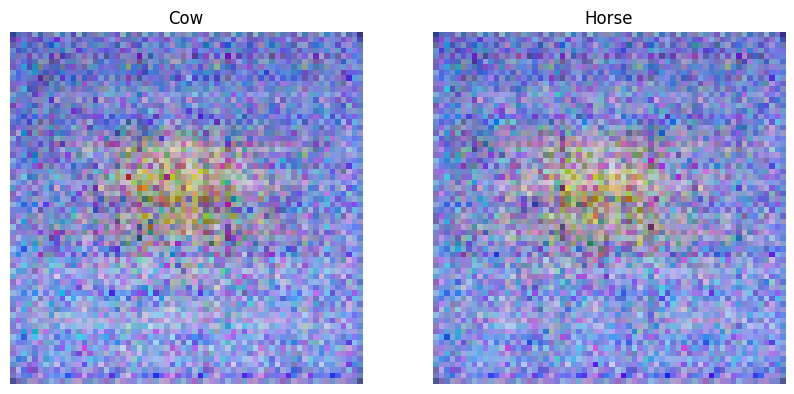

Starting epoch 11...
g_loss: 7.140856742858887, d_loss: 4.144743919372559
Starting epoch 12...
g_loss: 1.547263264656067, d_loss: 2.540576934814453
Starting epoch 13...
g_loss: 4.200631141662598, d_loss: 1.6747273206710815
Starting epoch 14...
g_loss: 5.903876781463623, d_loss: 1.4753525257110596
Starting epoch 15...
g_loss: 8.327566146850586, d_loss: 1.5330066680908203
Starting epoch 16...
g_loss: 2.8334579467773438, d_loss: 3.7049808502197266
Starting epoch 17...
g_loss: 4.296014308929443, d_loss: 1.0393402576446533
Starting epoch 18...
g_loss: 7.234633445739746, d_loss: 0.7997459769248962
Starting epoch 19...
g_loss: 0.9434877634048462, d_loss: 1.969125747680664
Starting epoch 20...


g_loss: 5.326208591461182, d_loss: 1.3203458786010742


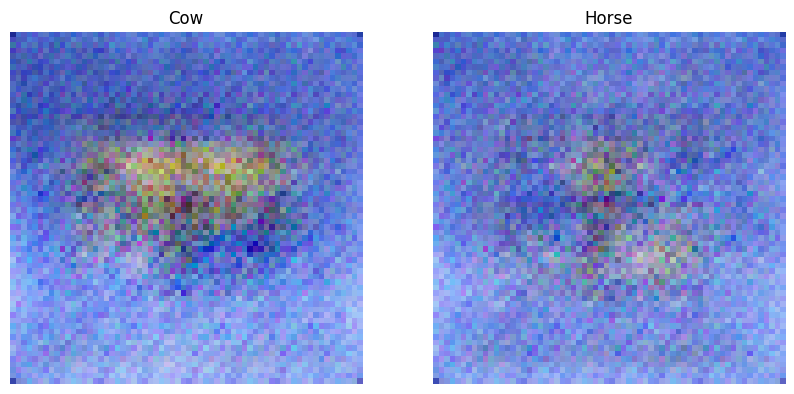

Starting epoch 21...
g_loss: 0.5990045070648193, d_loss: 2.729337215423584
Starting epoch 22...
g_loss: 3.2460689544677734, d_loss: 0.6469947099685669
Starting epoch 23...
g_loss: 1.4425084590911865, d_loss: 1.8797056674957275
Starting epoch 24...
g_loss: 4.6151885986328125, d_loss: 0.8612282872200012
Starting epoch 25...
g_loss: 3.945528268814087, d_loss: 1.032785177230835
Starting epoch 26...
g_loss: 0.6482877731323242, d_loss: 0.763597309589386
Starting epoch 27...
g_loss: 7.321687698364258, d_loss: 1.0273250341415405
Starting epoch 28...
g_loss: 3.5349929332733154, d_loss: 0.6573179960250854
Starting epoch 29...
g_loss: 4.681593418121338, d_loss: 0.359125554561615
Starting epoch 30...


g_loss: 5.307450294494629, d_loss: 0.34132319688796997


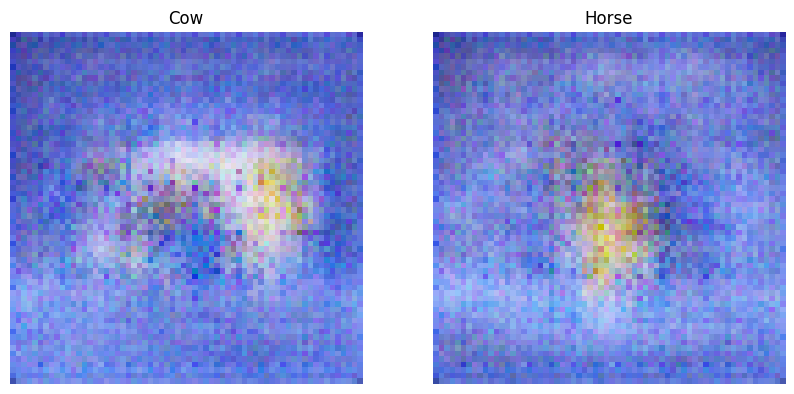

Starting epoch 31...
g_loss: 1.6547914743423462, d_loss: 0.7533103823661804
Starting epoch 32...
g_loss: 6.643449306488037, d_loss: 1.3861786127090454
Starting epoch 33...
g_loss: 0.8606941103935242, d_loss: 2.365461826324463
Starting epoch 34...
g_loss: 6.308630466461182, d_loss: 0.37343862652778625
Starting epoch 35...
g_loss: 4.107998371124268, d_loss: 0.9913551807403564
Starting epoch 36...
g_loss: 4.201495170593262, d_loss: 0.399636834859848
Starting epoch 37...
g_loss: 0.4675849974155426, d_loss: 1.6326062679290771
Starting epoch 38...
g_loss: 4.628701686859131, d_loss: 0.8412728309631348
Starting epoch 39...
g_loss: 3.7381577491760254, d_loss: 0.6433632373809814
Starting epoch 40...


g_loss: 1.9274425506591797, d_loss: 3.7456631660461426


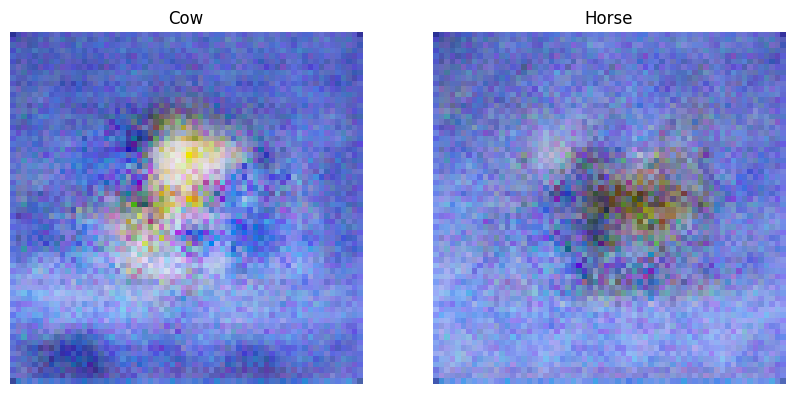

Starting epoch 41...
g_loss: 3.7257871627807617, d_loss: 0.8465256094932556
Starting epoch 42...
g_loss: 5.626598834991455, d_loss: 1.1882565021514893
Starting epoch 43...
g_loss: 3.5648038387298584, d_loss: 0.3899184465408325
Starting epoch 44...
g_loss: 5.199315071105957, d_loss: 0.22322750091552734
Starting epoch 45...
g_loss: 2.8791770935058594, d_loss: 0.40700897574424744
Starting epoch 46...
g_loss: 7.336666584014893, d_loss: 1.1192363500595093
Starting epoch 47...
g_loss: 1.0777556896209717, d_loss: 1.2345082759857178
Starting epoch 48...
g_loss: 4.577265739440918, d_loss: 0.2425023317337036
Starting epoch 49...
g_loss: 2.0507211685180664, d_loss: 1.1205552816390991
Starting epoch 50...


g_loss: 2.074010133743286, d_loss: 1.2469862699508667


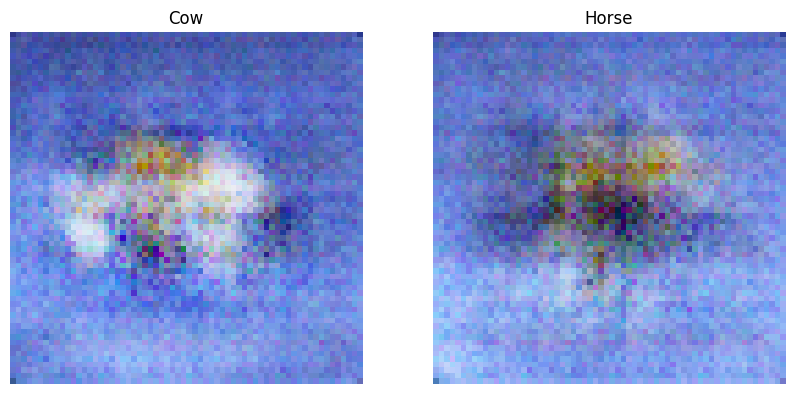

Starting epoch 51...
g_loss: 0.24888867139816284, d_loss: 1.944244623184204
Starting epoch 52...
g_loss: 0.7180966138839722, d_loss: 1.5199354887008667
Starting epoch 53...
g_loss: 2.5089097023010254, d_loss: 0.46396592259407043
Starting epoch 54...
g_loss: 4.9943389892578125, d_loss: 0.22681695222854614
Starting epoch 55...
g_loss: 3.9050464630126953, d_loss: 0.32877373695373535
Starting epoch 56...
g_loss: 1.5566060543060303, d_loss: 0.6538781523704529
Starting epoch 57...
g_loss: 4.074626922607422, d_loss: 0.16929900646209717
Starting epoch 58...
g_loss: 8.702960014343262, d_loss: 1.75676691532135
Starting epoch 59...
g_loss: 2.8632638454437256, d_loss: 0.5971183776855469
Starting epoch 60...


g_loss: 0.6554983258247375, d_loss: 1.1907200813293457


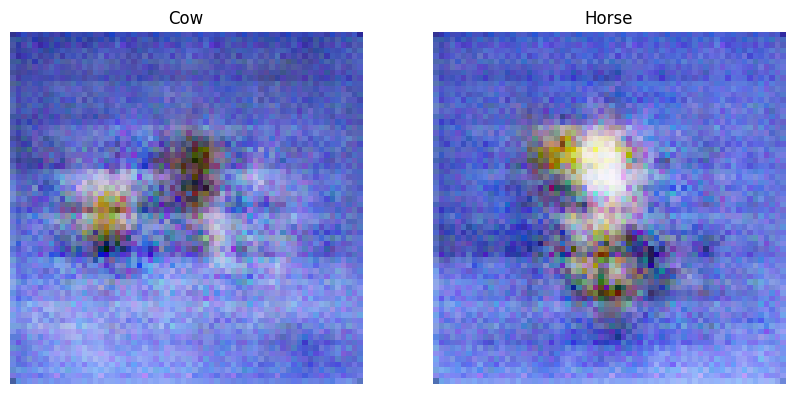

Starting epoch 61...
g_loss: 1.9974030256271362, d_loss: 0.5669000744819641
Starting epoch 62...
g_loss: 2.912552833557129, d_loss: 0.36202001571655273
Starting epoch 63...
g_loss: 5.086922645568848, d_loss: 0.8108114004135132
Starting epoch 64...
g_loss: 0.4734934866428375, d_loss: 1.398888349533081
Starting epoch 65...
g_loss: 2.8648245334625244, d_loss: 0.34193122386932373
Starting epoch 66...
g_loss: 6.431327819824219, d_loss: 0.9729605913162231
Starting epoch 67...
g_loss: 3.7781434059143066, d_loss: 1.424834132194519
Starting epoch 68...
g_loss: 5.538537502288818, d_loss: 0.8522883653640747
Starting epoch 69...
g_loss: 1.8284218311309814, d_loss: 0.8609415292739868
Starting epoch 70...


g_loss: 3.721942663192749, d_loss: 0.6359804272651672


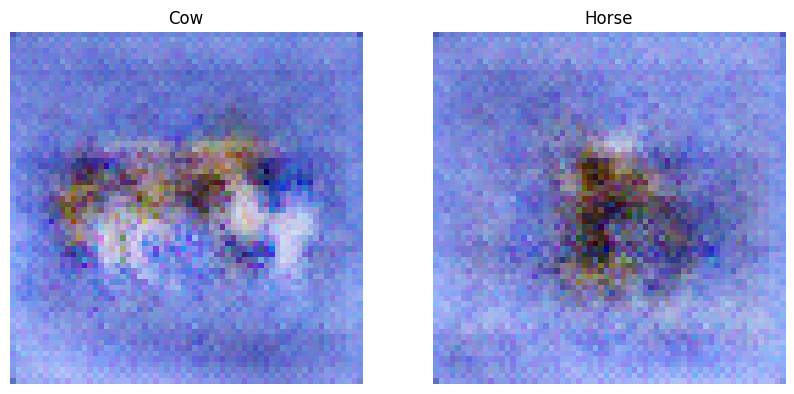

Starting epoch 71...
g_loss: 1.1997489929199219, d_loss: 1.096274971961975
Starting epoch 72...
g_loss: 1.8165866136550903, d_loss: 1.2186858654022217
Starting epoch 73...
g_loss: 3.726440191268921, d_loss: 0.214809849858284
Starting epoch 74...
g_loss: 2.6835532188415527, d_loss: 0.3884909152984619
Starting epoch 75...
g_loss: 5.72630500793457, d_loss: 0.5053521990776062
Starting epoch 76...
g_loss: 4.4672698974609375, d_loss: 0.40819448232650757
Starting epoch 77...
g_loss: 5.334897994995117, d_loss: 0.35707178711891174
Starting epoch 78...
g_loss: 5.301311492919922, d_loss: 1.1416816711425781
Starting epoch 79...
g_loss: 0.4922482371330261, d_loss: 1.433698058128357
Starting epoch 80...


g_loss: 3.6720659732818604, d_loss: 2.4819283485412598


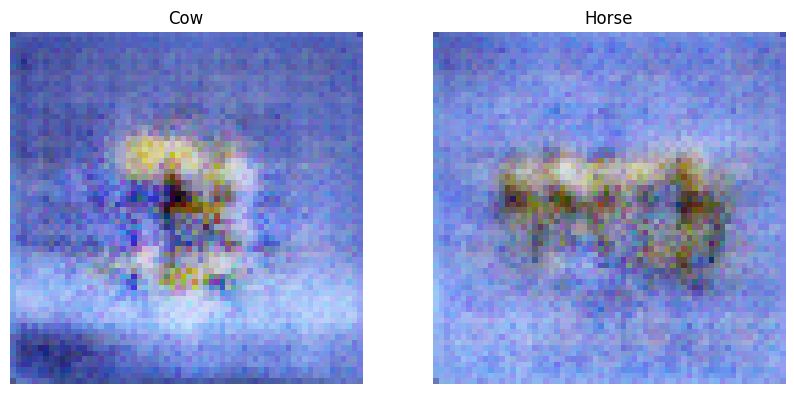

Starting epoch 81...
g_loss: 3.798704147338867, d_loss: 0.6934548616409302
Starting epoch 82...
g_loss: 3.1527204513549805, d_loss: 1.0694663524627686
Starting epoch 83...
g_loss: 4.531772613525391, d_loss: 0.43286964297294617
Starting epoch 84...
g_loss: 6.998840808868408, d_loss: 1.1957963705062866
Starting epoch 85...
g_loss: 1.2515538930892944, d_loss: 0.7513160109519958
Starting epoch 86...
g_loss: 3.8004989624023438, d_loss: 0.32939469814300537
Starting epoch 87...
g_loss: 4.045807361602783, d_loss: 0.8115818500518799
Starting epoch 88...
g_loss: 2.4703426361083984, d_loss: 0.9202775955200195
Starting epoch 89...
g_loss: 8.325334548950195, d_loss: 0.6258857846260071
Starting epoch 90...


g_loss: 3.31967830657959, d_loss: 0.9360194206237793


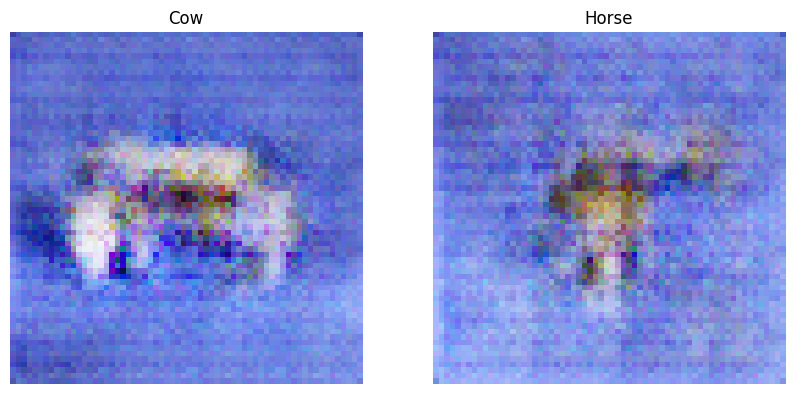

Starting epoch 91...
g_loss: 1.1111721992492676, d_loss: 0.8353380560874939
Starting epoch 92...
g_loss: 4.391016006469727, d_loss: 0.4410601258277893
Starting epoch 93...
g_loss: 0.8888272643089294, d_loss: 1.8395183086395264
Starting epoch 94...
g_loss: 3.5186309814453125, d_loss: 0.6537100672721863
Starting epoch 95...
g_loss: 4.779340744018555, d_loss: 0.20906411111354828
Starting epoch 96...
g_loss: 6.7467360496521, d_loss: 0.9924207329750061
Starting epoch 97...
g_loss: 4.919956207275391, d_loss: 0.57952880859375
Starting epoch 98...
g_loss: 1.8214480876922607, d_loss: 0.6048991084098816
Starting epoch 99...
g_loss: 0.6089311838150024, d_loss: 7.506657600402832
Starting epoch 100...


g_loss: 2.613311767578125, d_loss: 0.41446107625961304


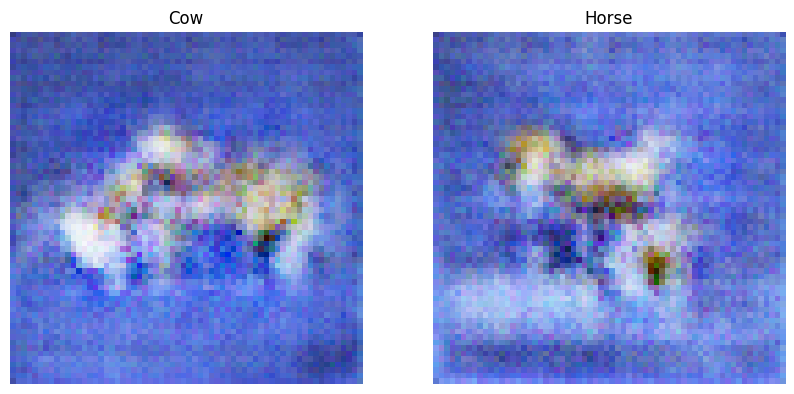

Starting epoch 101...
g_loss: 0.1331460326910019, d_loss: 3.5281741619110107
Starting epoch 102...
g_loss: 6.041375160217285, d_loss: 0.06131233647465706
Starting epoch 103...
g_loss: 3.853195905685425, d_loss: 0.2593657076358795
Starting epoch 104...
g_loss: 3.8987817764282227, d_loss: 0.2500607371330261
Starting epoch 105...
g_loss: 0.12272652983665466, d_loss: 2.6297037601470947
Starting epoch 106...
g_loss: 4.281740665435791, d_loss: 1.4405841827392578
Starting epoch 107...
g_loss: 3.823195457458496, d_loss: 0.16798456013202667
Starting epoch 108...
g_loss: 2.725790023803711, d_loss: 0.5313018560409546
Starting epoch 109...
g_loss: 0.399593710899353, d_loss: 1.2520058155059814
Starting epoch 110...


g_loss: 3.273364543914795, d_loss: 0.935332179069519


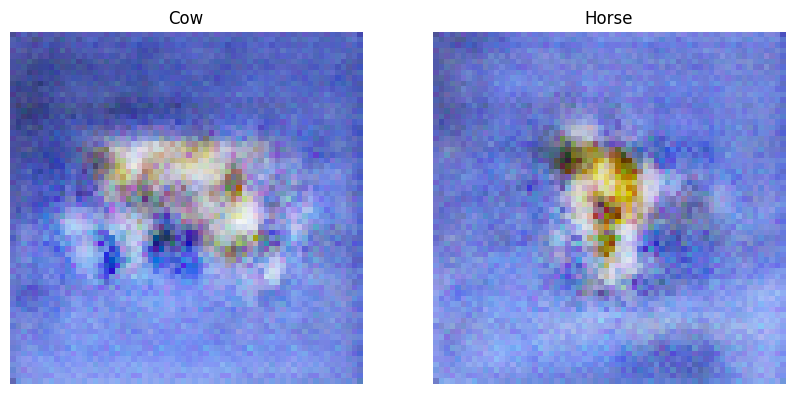

Starting epoch 111...
g_loss: 3.1231770515441895, d_loss: 0.2854267656803131
Starting epoch 112...
g_loss: 5.014795303344727, d_loss: 0.34761926531791687
Starting epoch 113...
g_loss: 3.274366855621338, d_loss: 0.12662649154663086
Starting epoch 114...
g_loss: 2.7649874687194824, d_loss: 0.24725256860256195
Starting epoch 115...
g_loss: 1.3780995607376099, d_loss: 1.0251771211624146
Starting epoch 116...
g_loss: 4.093769073486328, d_loss: 0.36432766914367676
Starting epoch 117...
g_loss: 2.059640407562256, d_loss: 0.6637217998504639
Starting epoch 118...
g_loss: 0.09324195981025696, d_loss: 3.3924341201782227
Starting epoch 119...
g_loss: 5.513812065124512, d_loss: 0.29658499360084534
Starting epoch 120...


g_loss: 3.701343059539795, d_loss: 0.3555602431297302


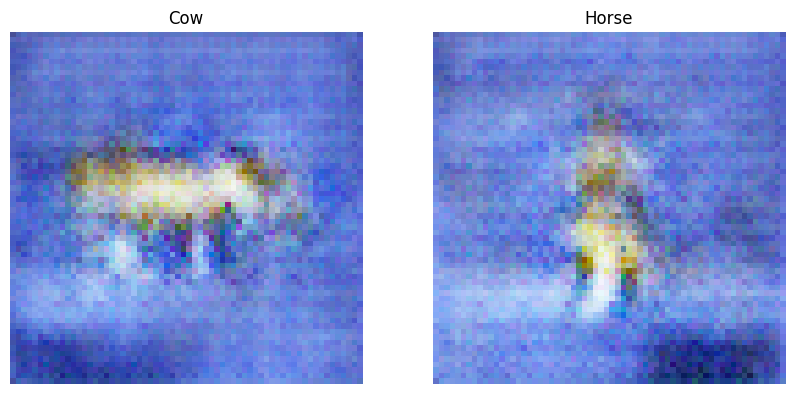

Starting epoch 121...
g_loss: 2.5244038105010986, d_loss: 0.5061522126197815
Starting epoch 122...
g_loss: 4.304348945617676, d_loss: 0.12290211766958237
Starting epoch 123...
g_loss: 2.3076958656311035, d_loss: 0.39873644709587097
Starting epoch 124...
g_loss: 2.218214273452759, d_loss: 0.5495808124542236
Starting epoch 125...
g_loss: 3.0633325576782227, d_loss: 0.8339418768882751
Starting epoch 126...
g_loss: 4.3451409339904785, d_loss: 0.20753923058509827
Starting epoch 127...
g_loss: 6.057537078857422, d_loss: 0.36882293224334717
Starting epoch 128...
g_loss: 2.534257411956787, d_loss: 0.49193206429481506
Starting epoch 129...
g_loss: 6.091775894165039, d_loss: 0.22993704676628113
Starting epoch 130...


g_loss: 4.835144996643066, d_loss: 0.26555630564689636


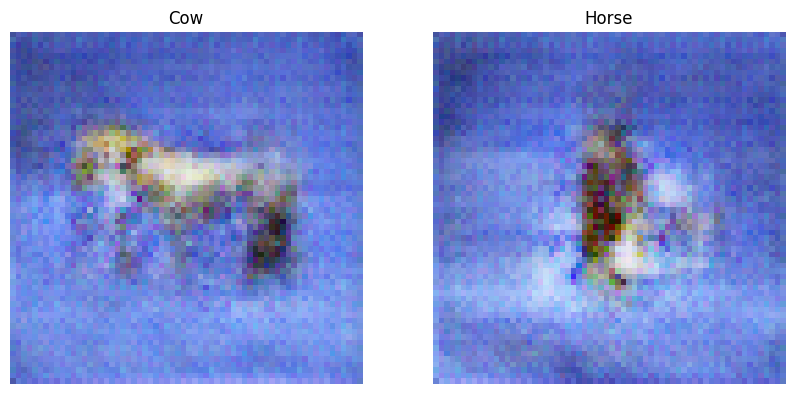

Starting epoch 131...
g_loss: 3.2207958698272705, d_loss: 0.28343385457992554
Starting epoch 132...
g_loss: 7.13346004486084, d_loss: 0.05416281148791313
Starting epoch 133...
g_loss: 0.31009793281555176, d_loss: 1.5887795686721802
Starting epoch 134...
g_loss: 3.6514410972595215, d_loss: 2.444810152053833
Starting epoch 135...
g_loss: 2.319200038909912, d_loss: 1.2731989622116089
Starting epoch 136...
g_loss: 5.9740729331970215, d_loss: 0.09206307679414749
Starting epoch 137...
g_loss: 1.5239850282669067, d_loss: 0.8826627731323242
Starting epoch 138...
g_loss: 3.8493971824645996, d_loss: 0.123692587018013
Starting epoch 139...
g_loss: 3.6599669456481934, d_loss: 0.22632132470607758
Starting epoch 140...


g_loss: 1.2056373357772827, d_loss: 0.9746929407119751


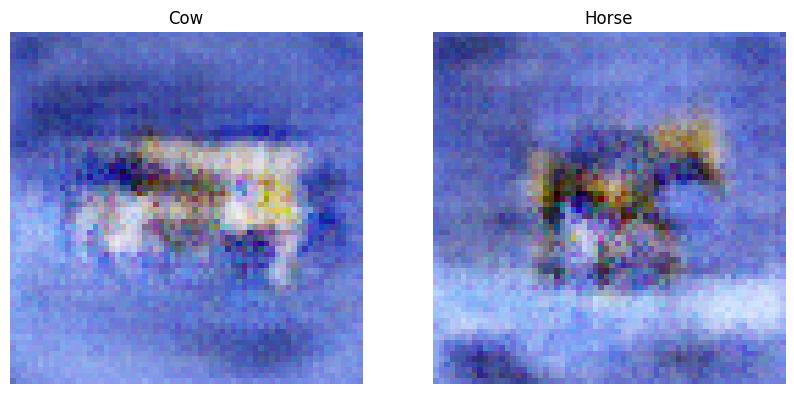

Starting epoch 141...
g_loss: 6.768340587615967, d_loss: 0.32727721333503723
Starting epoch 142...
g_loss: 4.220305919647217, d_loss: 0.20692957937717438
Starting epoch 143...
g_loss: 3.33573317527771, d_loss: 0.47212961316108704
Starting epoch 144...
g_loss: 5.2231221199035645, d_loss: 0.4549861550331116
Starting epoch 145...
g_loss: 1.4592864513397217, d_loss: 3.3968560695648193
Starting epoch 146...
g_loss: 2.2953145503997803, d_loss: 1.1920685768127441
Starting epoch 147...
g_loss: 1.7258191108703613, d_loss: 1.4828413724899292
Starting epoch 148...
g_loss: 3.7560935020446777, d_loss: 0.482681006193161
Starting epoch 149...
g_loss: 5.003538131713867, d_loss: 0.1935053914785385
Starting epoch 150...


g_loss: 3.5429039001464844, d_loss: 0.6305939555168152


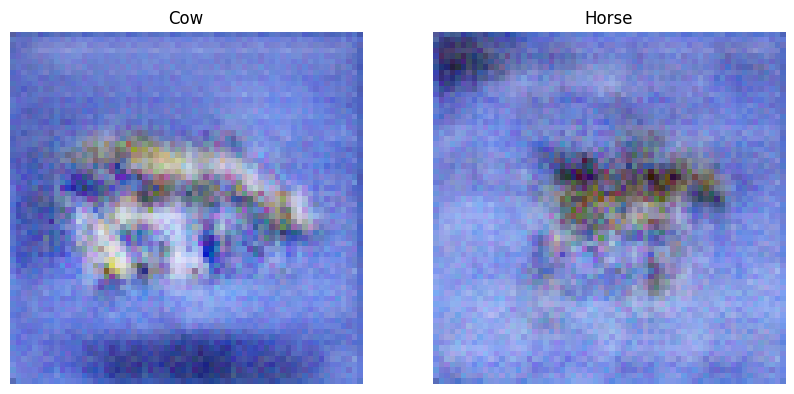

Starting epoch 151...
g_loss: 9.285404205322266, d_loss: 0.11793501675128937
Starting epoch 152...
g_loss: 0.8107856512069702, d_loss: 2.077448844909668
Starting epoch 153...
g_loss: 5.302792072296143, d_loss: 0.1560000479221344
Starting epoch 154...
g_loss: 2.667522668838501, d_loss: 1.564903974533081
Starting epoch 155...
g_loss: 4.7602996826171875, d_loss: 0.47004300355911255
Starting epoch 156...
g_loss: 4.7272796630859375, d_loss: 0.16340874135494232
Starting epoch 157...
g_loss: 5.699739933013916, d_loss: 0.05541590601205826
Starting epoch 158...
g_loss: 2.999598741531372, d_loss: 0.31355202198028564
Starting epoch 159...
g_loss: 5.67967414855957, d_loss: 0.3268551528453827
Starting epoch 160...


g_loss: 5.603795051574707, d_loss: 0.48214787244796753


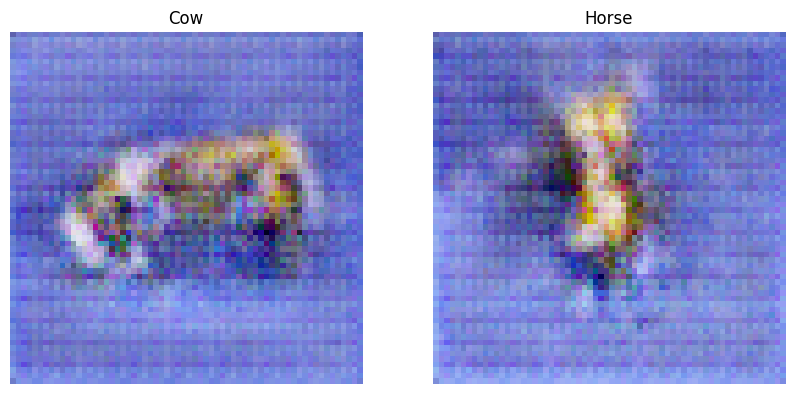

Starting epoch 161...
g_loss: 2.3247218132019043, d_loss: 0.4438439905643463
Starting epoch 162...
g_loss: 6.8393874168396, d_loss: 0.43120500445365906
Starting epoch 163...
g_loss: 5.288020133972168, d_loss: 0.2986907660961151
Starting epoch 164...
g_loss: 3.9624764919281006, d_loss: 0.35185956954956055
Starting epoch 165...
g_loss: 2.2955057621002197, d_loss: 0.44780147075653076
Starting epoch 166...
g_loss: 3.654939651489258, d_loss: 0.5143488645553589
Starting epoch 167...
g_loss: 4.363030433654785, d_loss: 0.13333454728126526
Starting epoch 168...
g_loss: 2.6680185794830322, d_loss: 0.36891213059425354
Starting epoch 169...
g_loss: 0.3378005027770996, d_loss: 0.9380615949630737
Starting epoch 170...


g_loss: 7.617397785186768, d_loss: 0.5910916924476624


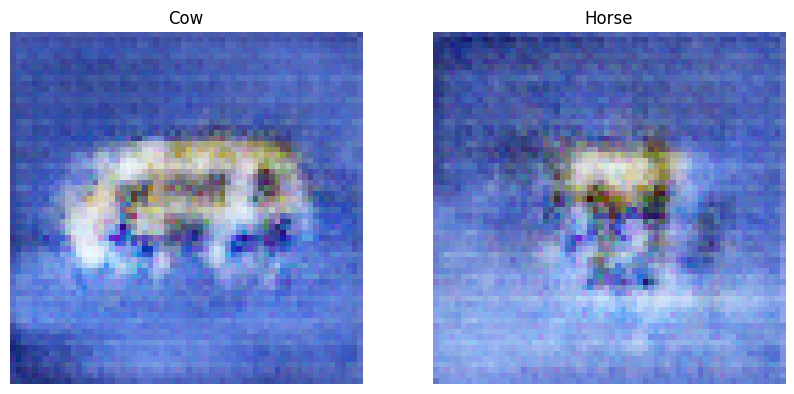

Starting epoch 171...
g_loss: 7.021955490112305, d_loss: 0.7101485133171082
Starting epoch 172...
g_loss: 2.451627254486084, d_loss: 0.8455979824066162
Starting epoch 173...
g_loss: 5.225441932678223, d_loss: 0.10916761308908463
Starting epoch 174...
g_loss: 4.396664142608643, d_loss: 0.21380743384361267
Starting epoch 175...
g_loss: 4.521071434020996, d_loss: 0.1182175725698471
Starting epoch 176...
g_loss: 2.2231764793395996, d_loss: 0.3999393582344055
Starting epoch 177...
g_loss: 1.8621999025344849, d_loss: 3.1598129272460938
Starting epoch 178...
g_loss: 5.590986251831055, d_loss: 0.11911487579345703
Starting epoch 179...
g_loss: 2.8862087726593018, d_loss: 0.42390865087509155
Starting epoch 180...


g_loss: 2.424628973007202, d_loss: 1.5613480806350708


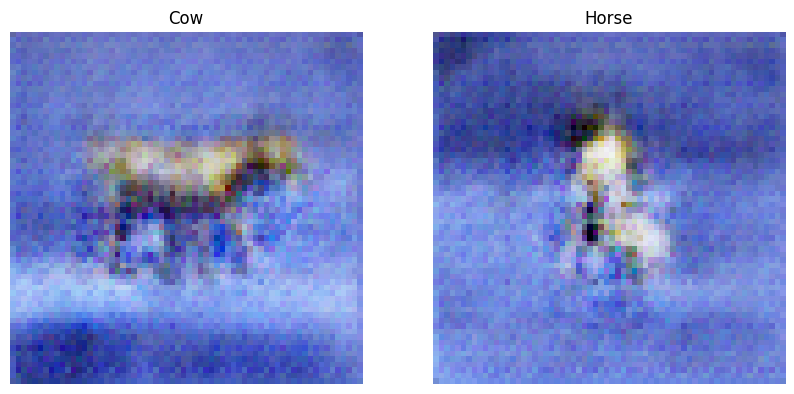

Starting epoch 181...
g_loss: 7.220752716064453, d_loss: 0.38906070590019226
Starting epoch 182...
g_loss: 2.2867672443389893, d_loss: 0.37510374188423157
Starting epoch 183...
g_loss: 5.717770099639893, d_loss: 0.1892572045326233
Starting epoch 184...
g_loss: 0.739422082901001, d_loss: 2.9192371368408203
Starting epoch 185...
g_loss: 4.801449775695801, d_loss: 0.3322630822658539
Starting epoch 186...
g_loss: 3.8573155403137207, d_loss: 0.2795248031616211
Starting epoch 187...
g_loss: 3.8621060848236084, d_loss: 0.14515972137451172
Starting epoch 188...
g_loss: 4.273447036743164, d_loss: 0.15919382870197296
Starting epoch 189...
g_loss: 0.7986441850662231, d_loss: 1.668752670288086
Starting epoch 190...


g_loss: 8.133419036865234, d_loss: 1.292206883430481


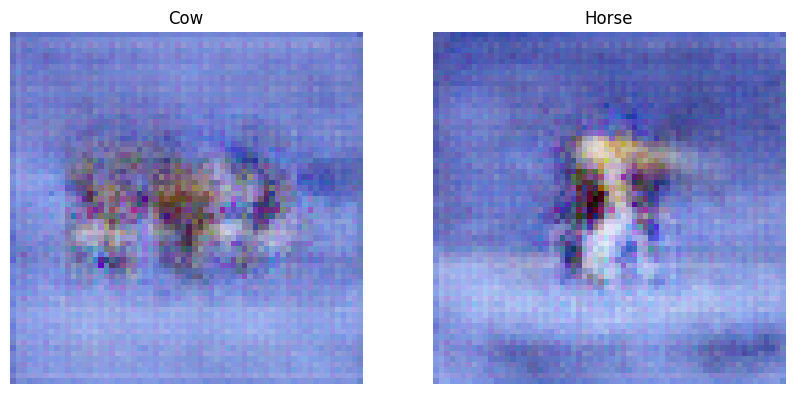

Starting epoch 191...
g_loss: 2.5219597816467285, d_loss: 0.8606573939323425
Starting epoch 192...
g_loss: 5.607640743255615, d_loss: 0.5442149639129639
Starting epoch 193...
g_loss: 4.451704978942871, d_loss: 0.286995530128479
Starting epoch 194...
g_loss: 3.4006991386413574, d_loss: 0.3056819438934326
Starting epoch 195...
g_loss: 6.038287162780762, d_loss: 0.011323736980557442
Starting epoch 196...
g_loss: 3.914834976196289, d_loss: 0.13873855769634247
Starting epoch 197...
g_loss: 2.1488804817199707, d_loss: 0.5211770534515381
Starting epoch 198...
g_loss: 6.056868553161621, d_loss: 0.30525943636894226
Starting epoch 199...
g_loss: 3.875054359436035, d_loss: 0.11700055003166199
Starting epoch 200...


g_loss: 1.0452073812484741, d_loss: 0.9118161201477051


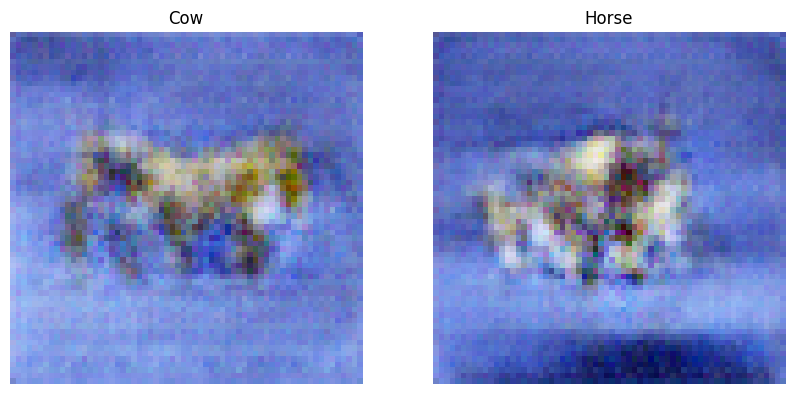

In [74]:
#Training GAN
print("Starting Training Loop...")


n_of_epochs = 200
loss_Discriminator = 0

for e in range(n_of_epochs):
    running_loss_D = 0.0
    print('Starting epoch {}...'.format(e+1))
    for i, (images,labels) in enumerate(trainloader, 0):

    #####################################################################
    ## Update Discriminator: maximize log(D(x/y)) + log(1 - D(G(z/y))) ##
    #####################################################################

        #Loss on real Images
        myDiscriminator.zero_grad()
        predicted = myDiscriminator(images.to(device),labels.to(device))
        loss_real = criterion(predicted, torch.ones((len(predicted)), 1, 1,1, dtype=torch.float, device=device).to(device))
        loss_real.backward(retain_graph=True)

        #Loss on fake Images
        z = (torch.randn(batch_size, z_size)).to(device)
        fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)
        fake_image = myGenerator(z.to(device),fake_labels)
        predicted = myDiscriminator(fake_image,fake_labels)
        loss_fake = criterion(predicted, torch.zeros((len(predicted)), 1, 1,1, dtype=torch.float, device=device).to(device))
        loss_fake.backward(retain_graph=True)
        loss_Discriminator = loss_real + loss_fake
        d_optimizer.step()

        #################################################
        ### Update Generator: maximize log(D(G(z/y))) ###
        #################################################

        myGenerator.zero_grad()
        predicted = myDiscriminator(fake_image,fake_labels)
        loss_gen = criterion(predicted, torch.ones((len(predicted)), 1, 1,1, dtype=torch.float, device=device).to(device))
        loss_gen.backward()
        g_optimizer.step()
        running_loss_D +=  loss_Discriminator.item()
    # Set generator eval

    print('g_loss: {}, d_loss: {}'.format(loss_gen, loss_Discriminator))
    if (e + 1) % 10 == 0:
      # Building z
      z1 = Variable(torch.randn(class_num-1, z_size)).to(device)
      z2 = Variable(torch.randn(class_num-1, z_size)).to(device)
      #labels
      label_cow = torch.tensor([0]).to(device)
      label_horse = torch.tensor([1]).to(device)

      # Generating images
      cow_image = myGenerator(z1, label_cow)
      cow_image = cow_image.detach().squeeze().permute(1, 2, 0).cpu().numpy()

      horse_image = myGenerator(z2, label_horse)
      horse_image = horse_image.detach().squeeze().permute(1, 2, 0).cpu().numpy()

      # plot images
      fig, axes = plt.subplots(1, 2, figsize=(10, 5))

      # Display the cow image in the first subplot
      axes[0].imshow(cow_image)
      axes[0].axis('off')  # Turn off axis labels for clarity
      axes[0].set_title('Cow')

      # Display the horse image in the second subplot
      axes[1].imshow(horse_image)
      axes[1].axis('off')  # Turn off axis labels for clarity
      axes[1].set_title('Horse')

      plt.show()

In [75]:
for i, (images,labels) in enumerate(trainloader, 0):

    #####################################################################
    ## Update Discriminator: maximize log(D(x/y)) + log(1 - D(G(z/y))) ##
    #####################################################################

        #Loss on real Images
        myDiscriminator.zero_grad()
        print(images.shape)
        print(labels.shape)
        predicted = myDiscriminator(images.to(device),labels.to(device))
        print(predicted)
        loss_real = criterion(predicted, torch.ones((len(predicted)), 1, 1,1, dtype=torch.float, device=device).to(device))
        break

torch.Size([16, 3, 64, 64])
torch.Size([16])
tensor([[[[0.9993]]],


        [[[0.9998]]],


        [[[0.9910]]],


        [[[0.9965]]],


        [[[0.9865]]],


        [[[0.9984]]],


        [[[0.9997]]],


        [[[1.0000]]],


        [[[0.9972]]],


        [[[0.9965]]],


        [[[0.9998]]],


        [[[0.9904]]],


        [[[0.9996]]],


        [[[0.9985]]],


        [[[0.9998]]],


        [[[0.9999]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [76]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):

    # Init gradient
    g_optimizer.zero_grad()

    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)

    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)

    # Generating fake images
    fake_images = generator(z, fake_labels)

    # Disciminating fake images
    validity = discriminator(fake_images, fake_labels)

    # Calculating discrimination loss (fake images)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))

    # Backword propagation
    g_loss.backward()

    #  Optimizing generator
    g_optimizer.step()

    return g_loss.data

In [77]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):

    # Init gradient
    d_optimizer.zero_grad()

    # Disciminating real images
    real_validity = discriminator(real_images, labels)

    # Calculating discrimination loss (real images)

    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))

    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)

    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)

    # Generating fake images

    fake_images = generator(z, fake_labels)

    # Disciminating fake images
    fake_validity = discriminator(fake_images, fake_labels)

    # Calculating discrimination loss (fake images)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))

    # Sum two losses
    d_loss = real_loss + fake_loss

    # Backword propagation
    d_loss.backward()

    # Optimizing discriminator
    d_optimizer.step()

    return d_loss.data

In [78]:
# epochs = 1000
# for epoch in range(epochs):

#     print('Starting epoch {}...'.format(epoch+1))

#     for i, (images, labels) in enumerate(trainloader):

#         # Train data
#         real_images = Variable(images).to(device)
#         labels = Variable(labels).to(device)

#         # Set generator train
#         myGenerator.train()

#         # Train discriminator

#         d_loss = discriminator_train_step(len(real_images), myDiscriminator,
#                                           myGenerator, d_optimizer, criterion,
#                                           real_images, labels)

#         # Train generator
#         g_loss = generator_train_step(batch_size, myDiscriminator, myGenerator, g_optimizer, criterion)

#     # Set generator eval
#     myGenerator.eval()

#     print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))

#     # Building z
#     z1 = Variable(torch.randn(class_num-1, z_size)).to(device)
#     z2 = Variable(torch.randn(class_num-1, z_size)).to(device)
#     #labels
#     label_cow = torch.tensor([0]).to(device)
#     label_horse = torch.tensor([1]).to(device)

#     # Generating images
#     cow_image = myGenerator(z1, label_cow)
#     cow_image = cow_image.detach().squeeze().permute(1, 2, 0).cpu().numpy()

#     horse_image = myGenerator(z2, label_horse)
#     horse_image = horse_image.detach().squeeze().permute(1, 2, 0).cpu().numpy()

#     # plot images
#     fig, axes = plt.subplots(1, 2, figsize=(10, 5))

#     # Display the cow image in the first subplot
#     axes[0].imshow(cow_image)
#     axes[0].axis('off')  # Turn off axis labels for clarity
#     axes[0].set_title('Cow')

#     # Display the horse image in the second subplot
#     axes[1].imshow(horse_image)
#     axes[1].axis('off')  # Turn off axis labels for clarity
#     axes[1].set_title('Horse')

#     plt.show()